In [21]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import numbers
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown, Latex


In [22]:
def norm(vec):
    return np.linalg.norm(vec, ord=np.inf)

# Algorithm: https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm.
# Note that all indecies are shifted by 1 towards 0.
def solveTridiagonal(mat, f):
    shape = mat.shape
    dim = len(f)
    assert shape[0] == dim and shape[1] == dim, "dimensions must be equal"

    a = np.diag(mat, -1)
    b = np.diag(mat,  0).copy()
    c = np.diag(mat,  1)
    d = f.copy()

    for i in range(1, dim):
        # a[i] -> a[i - 1], because algorithm starts counting 'a' from 2
        w = a[i-1] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]

    x = np.zeros(dim)
    x[dim-1] = d[dim-1] / b[dim-1]
    for i in reversed(range(0, dim-1)):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]

    assert norm(np.matmul(mat, x) - f) < 1e-9, 'tridiagonal method diverged, solution is incorrect'

    return x

## Уравнение в частных производных

Вычислительная математика для физиков (Петров, 2021), с.358

![title](res/10.png)

## Постановка задачи

In [23]:
class Grid:
    def __init__(self, x0, x1, y0, y1, Nx, Ny, init, left, right, bottom, top):
        self.hx = (x1 - x0) / Nx
        self.hy = (y1 - y0) / Ny
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1
        self.Nx = Nx + 2
        self.Ny = Ny + 2

        __U0 = np.full((self.Ny, self.Nx), float(init))
        __U0[ :,  0] = left
        __U0[ :, -1] = right
        __U0[ 0,  :] = bottom
        __U0[-1,  :] = top

        self.U0 = __U0
        self.zeroAngles()

    # Including border points.
    def getX(self):
        return np.linspace(self.x0 - self.hx, self.x1 + self.hx, self.Nx, endpoint=False)

    # Including border points.
    def getY(self):
        return np.linspace(self.y0 - self.hy, self.y1 + self.hy, self.Ny, endpoint=False)

    def zeroAngles(self):
        self.U0[ 0,  0] = 0
        self.U0[ 0, -1] = 0
        self.U0[-1,  0] = 0
        self.U0[-1, -1] = 0


def drawSol(grid, Un, showborder=False):
    x = grid.getX()
    x = np.append(x, x[-1] + x[1] - x[0])
    y = grid.getY()
    y = np.append(y, y[-1] + y[1] - y[0])
    plt.pcolormesh(x, y, Un, shading='flat')
    plt.colorbar()

    if not showborder:
        plt.xlim((grid.x0, grid.x1))
        plt.ylim((grid.y0, grid.y1))

    plt.xlabel('$x$')
    plt.ylabel('$y$')

    plt.show()

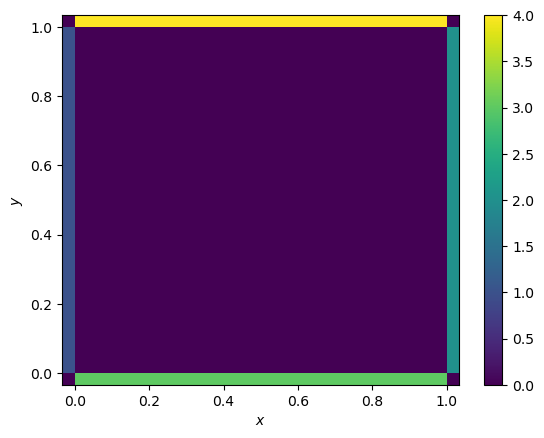

In [24]:
# grid = Grid(0, 1, 0, 1, 10, 5, 0, 4, 4, 4, 4)
grid = Grid(0, 1, 0, 1, 30, 30, 0, 1, 2, 3, 4)

drawSol(grid, grid.U0, showborder=True)

# For result comparison.
U_ref = {}
n_iter = 1000
tau = 0.0001

## Метод а)

Шаг 1. Решаем следующую систему. Вектор обозначает **строку** (при фиксированном $y$, которому соответствует индекс $l$). $l$ пробегает все возможные строки (меняется координата $y$).
$$
A_x \tilde{\vec{u}}_l =
\left(\begin{array}{ccccccc}
 1                    &  0                        &                           &                       &                       &                           &                       \\
 -\frac{\tau}{h_x^2}  &  1 + \frac{2\tau}{h_x^2}  &  -\frac{\tau}{h_x^2}      &                       &                       &                           &                       \\
                      &  -\frac{\tau}{h_x^2}      &  1 + \frac{2\tau}{h_x^2}  &  -\frac{\tau}{h_x^2}  &                       &                           &                       \\
                      &                           & ...                       & ...                   & ...                   &                           &                       \\
                      &                           &                           & ...                   & ...                   & ...                       &                       \\
                      &                           &                           &                       &  -\frac{\tau}{h_x^2}  &  1 + \frac{2\tau}{h_x^2}  &  -\frac{\tau}{h_x^2}  \\
                      &                           &                           &                       &                       &  0                        &  1                    \\
\end{array}\right)
\tilde{\vec{u}}_l = \vec{u}_l^n
$$
Шаг 2. Решаем следующую систему. Вектор обозначает **столбец**. $m$ пробегает все возможные столбцы (координата $x$).
$$
A_y \vec{u}_m^{n+1} =
\left(\begin{array}{ccccccc}
 1                    &  0                        &                           &                       &                       &                           &                       \\
 -\frac{\tau}{h_y^2}  &  1 + \frac{2\tau}{h_y^2}  &  -\frac{\tau}{h_y^2}      &                       &                       &                           &                       \\
                      &  -\frac{\tau}{h_y^2}      &  1 + \frac{2\tau}{h_y^2}  &  -\frac{\tau}{h_y^2}  &                       &                           &                       \\
                      &                           & ...                       & ...                   & ...                   &                           &                       \\
                      &                           &                           & ...                   & ...                   & ...                       &                       \\
                      &                           &                           &                       &  -\frac{\tau}{h_y^2}  &  1 + \frac{2\tau}{h_y^2}  &  -\frac{\tau}{h_y^2}  \\
                      &                           &                           &                       &                       &  0                        &  1                    \\
\end{array}\right)
\vec{u}_m^{n+1} = \tilde{\vec{u}}_m
$$

Матрицы отличаются только $h_x \leftrightarrow h_y$.

In [25]:
def solvePartial1(grid, tau, n_iter):
    def getA(N, tau, h):
        mid = np.concatenate((np.array([1]), np.full(N-2, 1 + 2*tau/h**2), np.array([1])))
        top = np.concatenate((np.array([0]), np.full(N-2, -tau/h**2)))
        bot = np.concatenate((np.full(N-2, -tau/h**2), np.array([0])))
        return np.diag(mid, 0) + np.diag(top, 1) + np.diag(bot, -1)

    Ny, Nx = grid.U0.shape
    Ax = getA(Nx, tau, grid.hx)
    Ay = getA(Ny, tau, grid.hy)

    U_list = [np.copy(grid.U0)]
    for n in range(n_iter):
        # Step 1.
        Un = U_list[n]
        Uaux = np.copy(Un)
        # Note: Don't evaluate border rows.
        for l in range(1, Ny-1):
            # sol = np.linalg.solve(Ax, Un[l])
            sol = solveTridiagonal(Ax, Un[l])
            Uaux[l] = sol

        # Step 2. To get columns as rows we use transpose.
        UauxT = np.transpose(Uaux)
        UnewT = np.transpose(Un).copy()
        # Note: Don't evaluate border columns.
        for m in range(1, Nx-1):
            # sol = np.linalg.solve(Ay, UauxT[m])
            sol = solveTridiagonal(Ay, UauxT[m])
            UnewT[m] = sol

        U_list.append(np.transpose(UnewT))

    return U_list


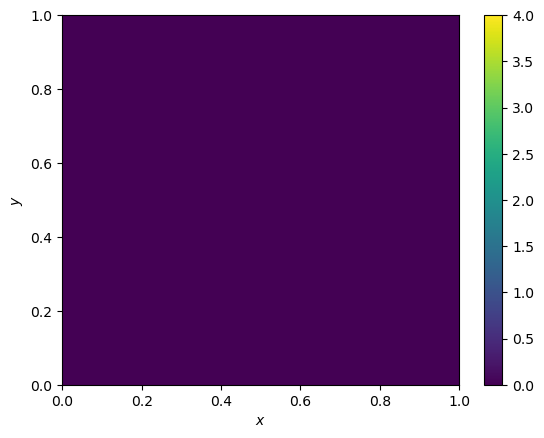

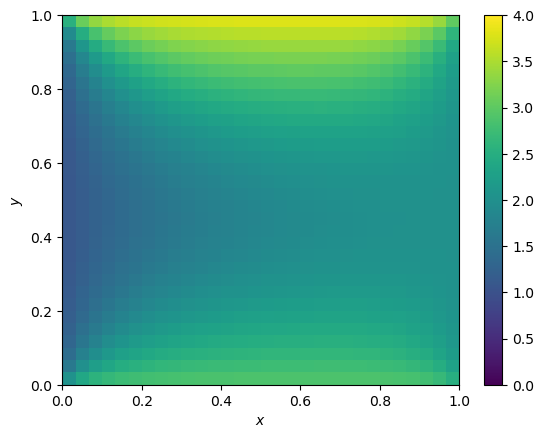

In [26]:
U_list = solvePartial1(grid, tau, n_iter)
drawSol(grid, U_list[0])
drawSol(grid, U_list[-1])

U_ref['a1'] = U_list[-1].copy()
U_list = solvePartial1(grid, tau**2, n_iter)
U_ref['a2'] = U_list[-1].copy()


## Метод б)

Шаг 1. Решаем следующую систему. Вектор обозначает **строку** (при фиксированном $y$, которому соответствует индекс $l$). $l$ пробегает все возможные строки (меняется координата $y$).
$$
A_x^{(1)} \vec{u}_l^{n+1/2} = A_x^{(2)} \vec{u}_l^n
$$
$$
\left(\begin{array}{ccccccc}
 1                       &  0                           &                              &                          &                          &                              &                          \\
 -\frac{\xi\tau}{h_x^2}  &  1 + \frac{2\xi\tau}{h_x^2}  &  -\frac{\xi\tau}{h_x^2}      &                          &                          &                              &                          \\
                         &  -\frac{\xi\tau}{h_x^2}      &  1 + \frac{2\xi\tau}{h_x^2}  &  -\frac{\xi\tau}{h_x^2}  &                          &                              &                          \\
                         &                              & ...                          & ...                      & ...                      &                              &                          \\
                         &                              &                              & ...                      & ...                      & ...                          &                          \\
                         &                              &                              &                          &  -\frac{\xi\tau}{h_x^2}  &  1 + \frac{2\xi\tau}{h_x^2}  &  -\frac{\xi\tau}{h_x^2}  \\
                         &                              &                              &                          &                          &  0                           &  1                       \\
\end{array}\right)
\vec{u}_l^{n+1/2}
=
\left(\begin{array}{ccccccc}
 1                          &  0                               &                                  &                             &                             &                                  &                             \\
 \frac{(1-\xi)\tau}{h_x^2}  &  1 - \frac{2(1-\xi)\tau}{h_x^2}  &  \frac{(1-\xi)\tau}{h_x^2}       &                             &                             &                                  &                             \\
                            &  \frac{(1-\xi)\tau}{h_x^2}       &  1 - \frac{2(1-\xi)\tau}{h_x^2}  &  \frac{(1-\xi)\tau}{h_x^2}  &                             &                                  &                             \\
                            &                                  & ...                              & ...                         & ...                         &                                  &                             \\
                            &                                  &                                  & ...                         & ...                         & ...                              &                             \\
                            &                                  &                                  &                             &  \frac{(1-\xi)\tau}{h_x^2}  &  1 - \frac{2(1-\xi)\tau}{h_x^2}  &  \frac{(1-\xi)\tau}{h_x^2}  \\
                            &                                  &                                  &                             &                             &  0                               &  1                          \\
\end{array}\right)
\vec{u}_l^n
$$
Шаг 2. Решаем следующую систему. Вектор обозначает **столбец**. $m$ пробегает все возможные столбцы (координата $x$).
$$
A_y^{(1)} \vec{u}_m^{n+1} = A_x^{(2)} \vec{u}_m^{n+1/2}
$$
$$
\left(\begin{array}{ccccccc}
 1                       &  0                           &                              &                          &                          &                              &                          \\
 -\frac{\xi\tau}{h_y^2}  &  1 + \frac{2\xi\tau}{h_y^2}  &  -\frac{\xi\tau}{h_y^2}      &                          &                          &                              &                          \\
                         &  -\frac{\xi\tau}{h_y^2}      &  1 + \frac{2\xi\tau}{h_y^2}  &  -\frac{\xi\tau}{h_y^2}  &                          &                              &                          \\
                         &                              & ...                          & ...                      & ...                      &                              &                          \\
                         &                              &                              & ...                      & ...                      & ...                          &                          \\
                         &                              &                              &                          &  -\frac{\xi\tau}{h_y^2}  &  1 + \frac{2\xi\tau}{h_y^2}  &  -\frac{\xi\tau}{h_y^2}  \\
                         &                              &                              &                          &                          &  0                           &  1                       \\
\end{array}\right)
\vec{u}_m^{n+1}
=
\left(\begin{array}{ccccccc}
 1                          &  0                               &                                  &                             &                             &                                  &                             \\
 \frac{(1-\xi)\tau}{h_y^2}  &  1 - \frac{2(1-\xi)\tau}{h_y^2}  &  \frac{(1-\xi)\tau}{h_y^2}       &                             &                             &                                  &                             \\
                            &  \frac{(1-\xi)\tau}{h_y^2}       &  1 - \frac{2(1-\xi)\tau}{h_y^2}  &  \frac{(1-\xi)\tau}{h_y^2}  &                             &                                  &                             \\
                            &                                  & ...                              & ...                         & ...                         &                                  &                             \\
                            &                                  &                                  & ...                         & ...                         & ...                              &                             \\
                            &                                  &                                  &                             &  \frac{(1-\xi)\tau}{h_y^2}  &  1 - \frac{2(1-\xi)\tau}{h_y^2}  &  \frac{(1-\xi)\tau}{h_y^2}  \\
                            &                                  &                                  &                             &                             &  0                               &  1                          \\
\end{array}\right)
\vec{u}_m^{n+1/2}
$$
Матрицы отличаются только $h_x \leftrightarrow h_y, \quad \xi \leftrightarrow -(1-\xi)$.

In [27]:
def solvePartial2(grid, tau, n_iter):
    def getA(N, tau, h, xi):
        mid = np.concatenate((np.array([1]), np.full(N-2, 1 + 2*xi*tau/h**2), np.array([1])))
        top = np.concatenate((np.array([0]), np.full(N-2, -xi*tau/h**2)))
        bot = np.concatenate((np.full(N-2, -xi*tau/h**2), np.array([0])))
        return np.diag(mid, 0) + np.diag(top, 1) + np.diag(bot, -1)

    xi = 1/2
    Ny, Nx = grid.U0.shape
    Ax1 = getA(Nx, tau, grid.hx, xi)
    Ax2 = getA(Nx, tau, grid.hx, -(1-xi))
    Ay1 = getA(Ny, tau, grid.hy, xi)
    Ay2 = getA(Ny, tau, grid.hy, -(1-xi))

    U_list = [np.copy(grid.U0)]
    for n in range(n_iter):
        # Step 1.
        Un = U_list[n]
        Uaux = np.copy(Un)
        # Note: Don't evaluate border rows.
        for l in range(1, Ny-1):
            # sol = np.linalg.solve(Ax1, np.matmul(Ax2, Un[l]))
            sol = solveTridiagonal(Ax1, np.matmul(Ax2, Un[l]))
            Uaux[l] = sol

        # Step 2. To get columns as rows we use transpose.
        UauxT = np.transpose(Uaux)
        UnewT = np.transpose(Un).copy()
        # Note: Don't evaluate border columns.
        for m in range(1, Nx-1):
            # sol = np.linalg.solve(Ay1, np.matmul(Ay2, UauxT[m]))
            sol = solveTridiagonal(Ay1, np.matmul(Ay2, UauxT[m]))
            UnewT[m] = sol

        U_list.append(np.transpose(UnewT))

    return U_list


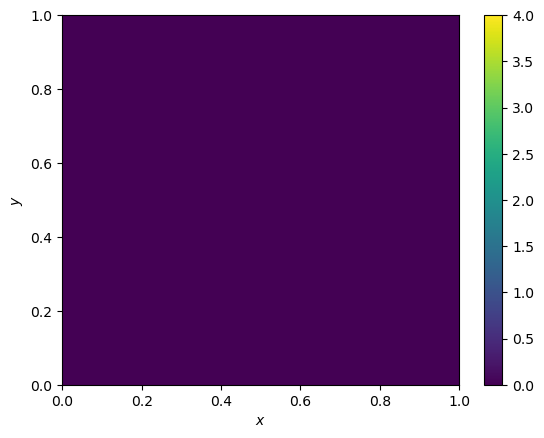

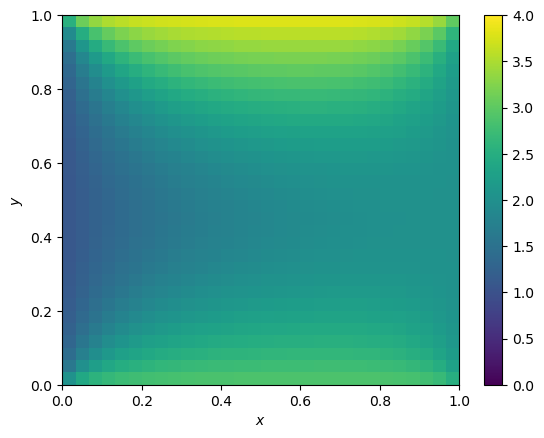

In [28]:
U_list = solvePartial2(grid, tau, n_iter)
drawSol(grid, U_list[0])
drawSol(grid, U_list[-1])

U_ref['b1'] = U_list[-1].copy()
U_list = solvePartial2(grid, tau**2, n_iter)
U_ref['b2'] = U_list[-1].copy()


## Метод в)

Метод в) не реализовывал, потому что опечатки покрывают больше половины формулы. Не уверен, какой именно он должен быть. 

## Метод г)

Шаг 1. Решаем следующую систему. Вектор обозначает **строку** (при фиксированном $y$, которому соответствует индекс $l$). $l$ пробегает все возможные строки (меняется координата $y$).
$$
\tilde{\vec{u}}_l = A_x \vec{u}_l^n
=
\left(\begin{array}{ccccccc}
 1                    &  0                        &                           &                       &                       &                           &                       \\
  \frac{\tau}{h_x^2}  &  1 - \frac{2\tau}{h_x^2}  &   \frac{\tau}{h_x^2}      &                       &                       &                           &                       \\
                      &   \frac{\tau}{h_x^2}      &  1 - \frac{2\tau}{h_x^2}  &   \frac{\tau}{h_x^2}  &                       &                           &                       \\
                      &                           & ...                       & ...                   & ...                   &                           &                       \\
                      &                           &                           & ...                   & ...                   & ...                       &                       \\
                      &                           &                           &                       &   \frac{\tau}{h_x^2}  &  1 - \frac{2\tau}{h_x^2}  &   \frac{\tau}{h_x^2}  \\
                      &                           &                           &                       &                       &  0                        &  1                    \\
\end{array}\right)
\vec{u}_l^n
$$
Шаг 2. Решаем следующую систему. Вектор обозначает **столбец**. $m$ пробегает все возможные столбцы (координата $x$).
$$
\vec{u}_m^{n+1} = A_y \tilde{\vec{u}}_m
=
\left(\begin{array}{ccccccc}
 1                    &  0                        &                           &                       &                       &                           &                       \\
  \frac{\tau}{h_y^2}  &  1 - \frac{2\tau}{h_y^2}  &   \frac{\tau}{h_y^2}      &                       &                       &                           &                       \\
                      &   \frac{\tau}{h_y^2}      &  1 - \frac{2\tau}{h_y^2}  &   \frac{\tau}{h_y^2}  &                       &                           &                       \\
                      &                           & ...                       & ...                   & ...                   &                           &                       \\
                      &                           &                           & ...                   & ...                   & ...                       &                       \\
                      &                           &                           &                       &   \frac{\tau}{h_y^2}  &  1 - \frac{2\tau}{h_y^2}  &   \frac{\tau}{h_y^2}  \\
                      &                           &                           &                       &                       &  0                        &  1                    \\
\end{array}\right)
\tilde{\vec{u}}_m
$$

Матрицы отличаются только $h_x \leftrightarrow h_y$.

In [29]:
def solvePartial4(grid, tau, n_iter):
    def getA(N, tau, h):
        mid = np.concatenate((np.array([1]), np.full(N-2, 1 - 2*tau/h**2), np.array([1])))
        top = np.concatenate((np.array([0]), np.full(N-2, tau/h**2)))
        bot = np.concatenate((np.full(N-2, tau/h**2), np.array([0])))
        return np.diag(mid, 0) + np.diag(top, 1) + np.diag(bot, -1)

    Ny, Nx = grid.U0.shape
    Ax = getA(Nx, tau, grid.hx)
    Ay = getA(Ny, tau, grid.hy)

    U_list = [np.copy(grid.U0)]
    for n in range(n_iter):
        # Step 1.
        Un = U_list[n]
        Uaux = np.copy(Un)
        # Note: Don't evaluate border rows.
        for l in range(1, Ny-1):
            sol = np.matmul(Ax, Un[l])
            Uaux[l] = sol

        # Step 2. To get columns as rows we use transpose.
        UauxT = np.transpose(Uaux)
        UnewT = np.transpose(Un).copy()
        # Note: Don't evaluate border columns.
        for m in range(1, Nx-1):
            sol = np.matmul(Ay, UauxT[m])
            UnewT[m] = sol

        U_list.append(np.transpose(UnewT))

    return U_list


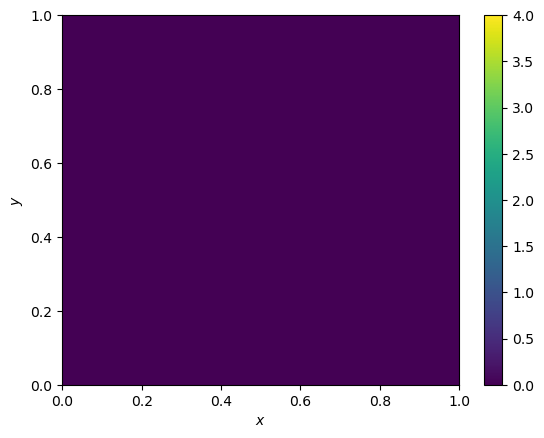

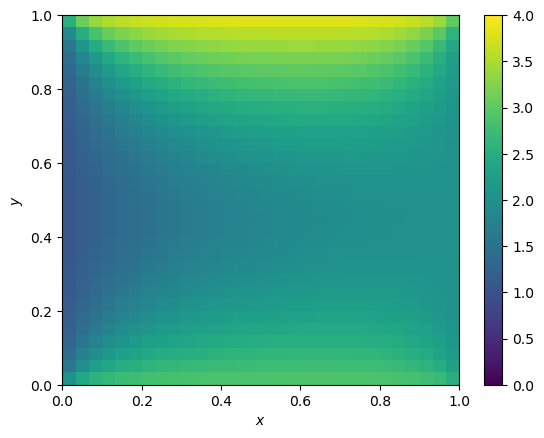

In [30]:
U_list = solvePartial4(grid, tau, n_iter)
drawSol(grid, U_list[0])
drawSol(grid, U_list[-1])

U_ref['d1'] = U_list[-1].copy()
U_list = solvePartial4(grid, tau**2, n_iter)
U_ref['d2'] = U_list[-1].copy()

## Сравнение

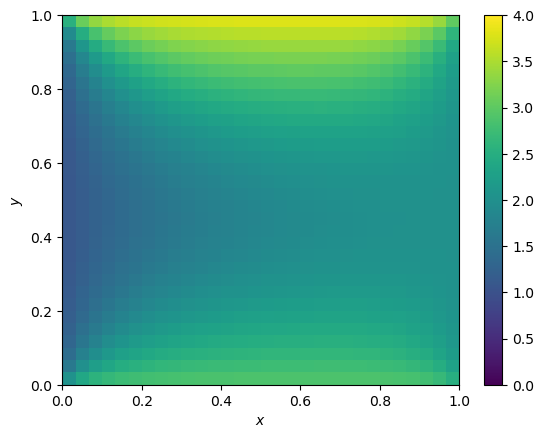

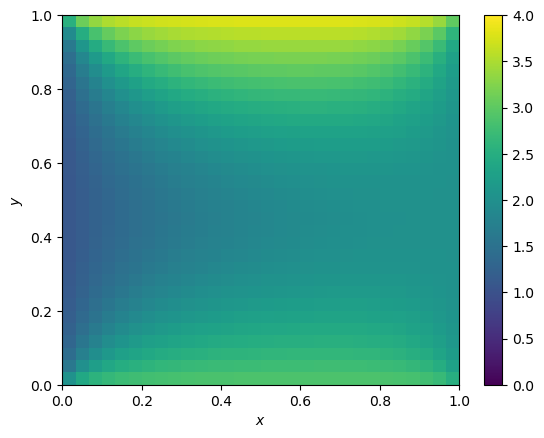

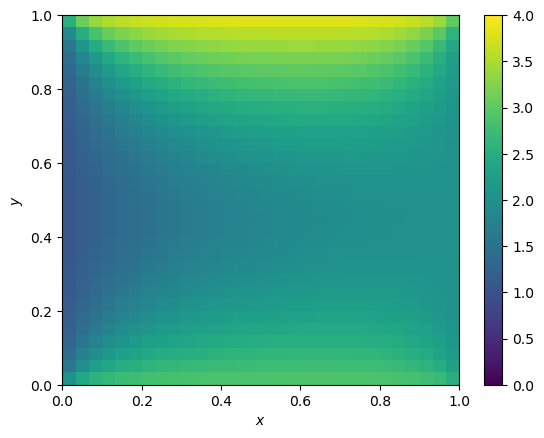

In [31]:
drawSol(grid, U_ref['a1'])
drawSol(grid, U_ref['b1'])
drawSol(grid, U_ref['d1'])

При увеличении степени $\tau$ в два раза точность улучшилась более, чем в два раза. Значит, асимптотически метод не хуже, чем $O(\tau)$

In [32]:
display(Latex(f'$\#iters = {n_iter}$'))
display(Latex(f'$\\tau = {tau}$'))
print(abs(U_ref['b1'] - U_ref['a1']).max())
print(abs(U_ref['d1'] - U_ref['a1']).max())
print(abs(U_ref['d1'] - U_ref['b1']).max())

display(Latex(f'$\\tau = {tau**2}$'))
print(abs(U_ref['b2'] - U_ref['a2']).max())
print(abs(U_ref['d2'] - U_ref['a2']).max())
print(abs(U_ref['d2'] - U_ref['b2']).max())


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.010585589857731614
0.022329155600166573
0.011743565742434958


<IPython.core.display.Latex object>

4.7095915905320807e-07
9.419287124862175e-07
4.709695534330094e-07


## Зависимость от времени

In [33]:
n_iter = 2048
U_list = solvePartial1(grid, tau, n_iter)

1


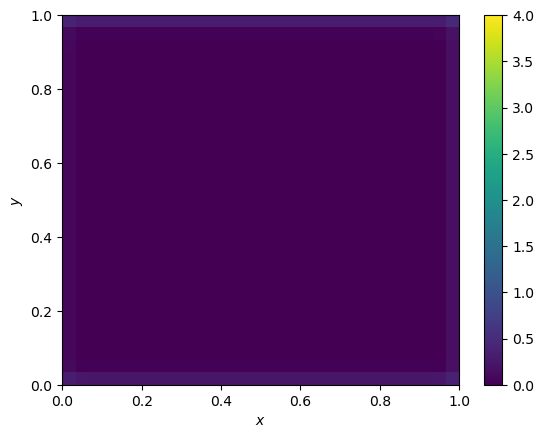

2


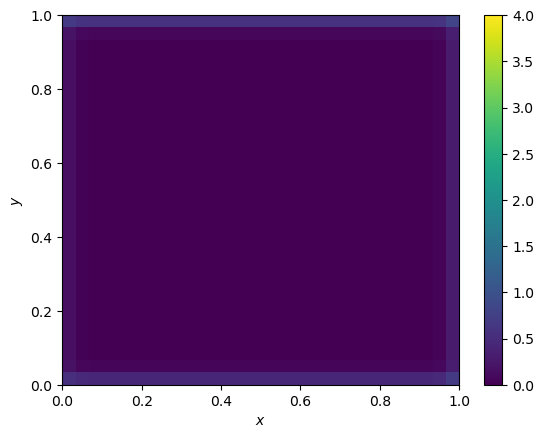

4


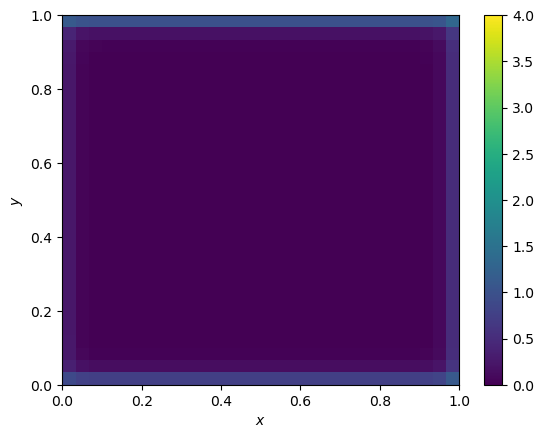

8


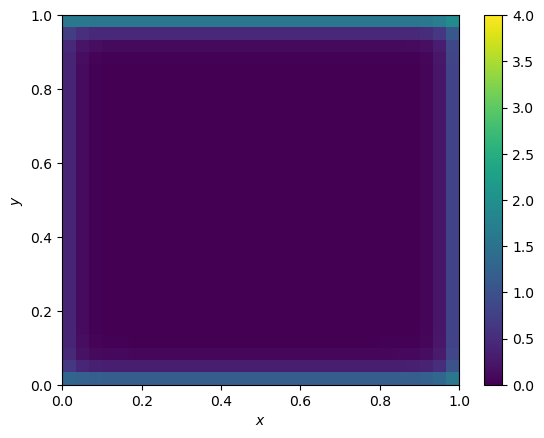

16


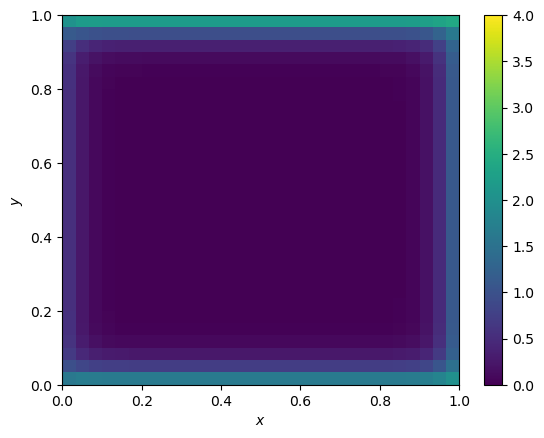

32


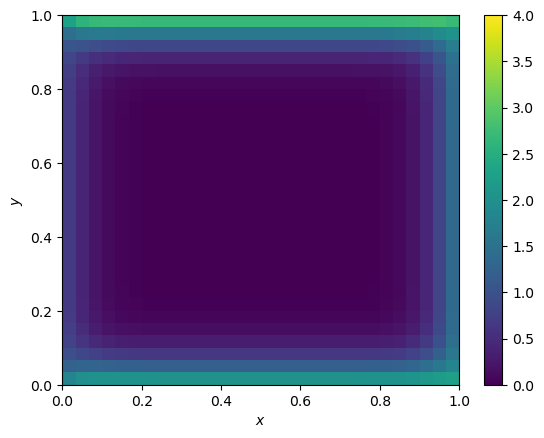

64


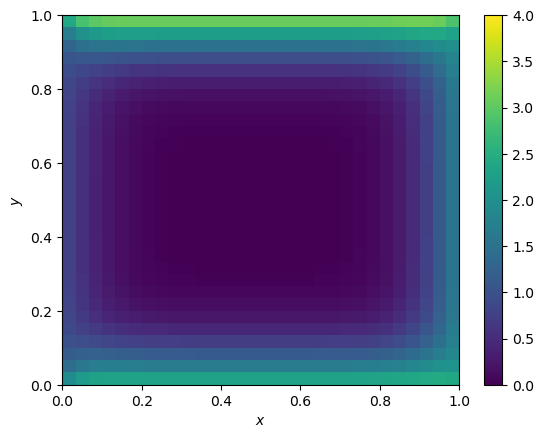

128


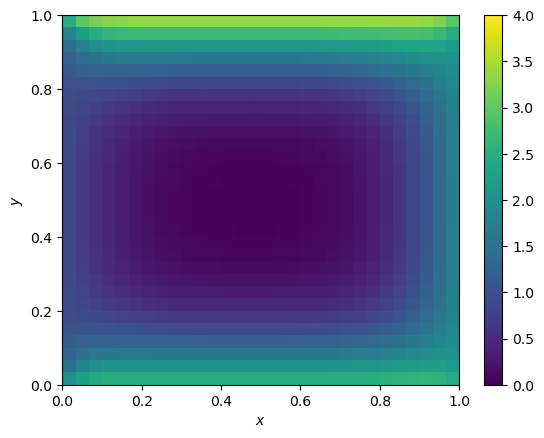

256


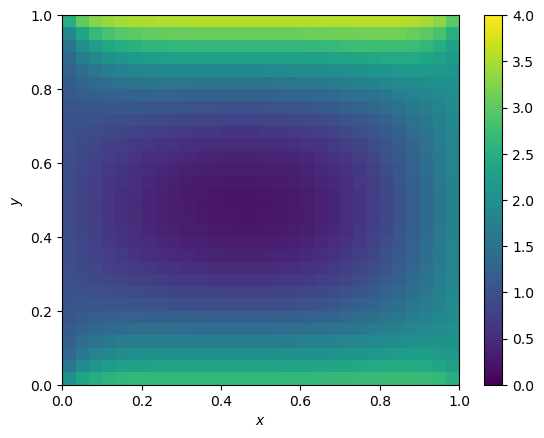

512


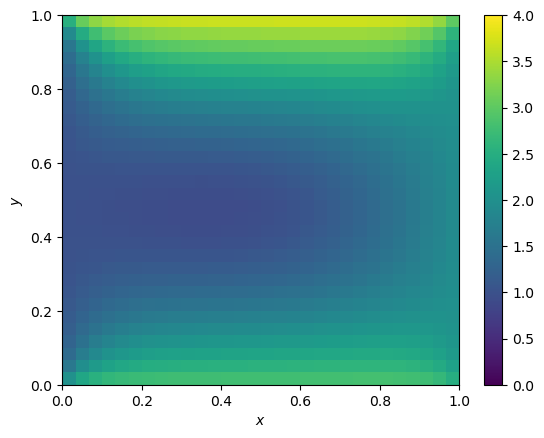

1024


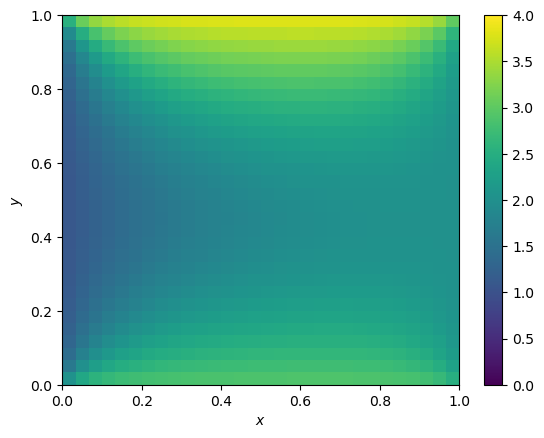

2048


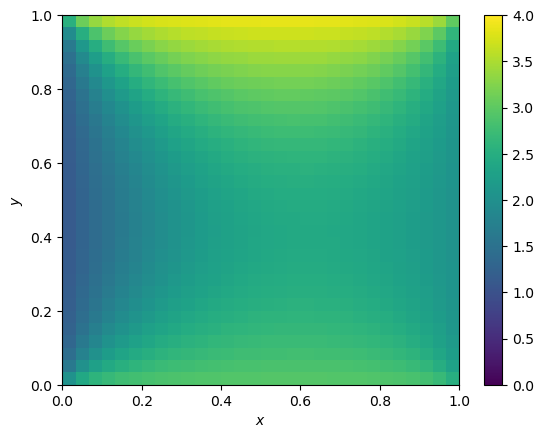

In [34]:
for i in range(int(np.log2(n_iter)) + 1):
    n = 2**i
    print(n)
    drawSol(grid, U_list[n])
